# Mini-Projet `MNIST`
Auteurs: *Emilie GALLAND*, *Léo BRENDLE*, *Fouad AFANE*


## Introduction

Le jeu de données MNIST est un classique du machine learning. Il contient des images de chiffres manuscrits (de 0 à 9) utilisées pour des tâches de reconnaissance automatique. Ce jeu de données comprend 60 000 exemples pour l’apprentissage et 10 000 pour le test. Chaque image fait 28×28 pixels, soit 784 variables par observation.

L’objectif de ce travail est de comparer plusieurs méthodes de classification sur ce jeu de données. Les modèles seront entraînés sur l’échantillon train et testés sur l’échantillon test. Lorsque ce sera utile, les hyperparamètres seront ajustés par validation croisée à 10 plis.
On utilisera des méthodes linéaires et non linéaires, en mode multiclasse direct ou avec une approche One-Versus-All.

**Plan**
1. Description du jeu de données
2. k plus proches voisins (k-NN)
3. Régression logistique
4. Analyse discriminante linéaire (LDA)
5. Random Forest
6. SVM à noyau gaussien
7. XGBoost
8. Comparaison et conclusion

## Chargement des librairies et des données

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

col_names = ['Y'] + [f'X{i}' for i in range(1, 785)]
mnist_train = pd.read_csv("mnist_train.csv", sep=",", names=col_names, header=None)
mnist_test = pd.read_csv("mnist_test.csv", sep=",", names=col_names, header=None)

mnist_train['Y'] = mnist_train['Y'].astype('category')
mnist_test['Y'] = mnist_test['Y'].astype('category')

## 1. Jeu de données

Le jeu de données MNIST (Modified National Institute of Standards and Technology) est une grande base d'images représentant des chiffres écrits à la main. Il est souvent utilisé en intelligence artificielle pour tester les performances de modèles, pour des tâches comme le débruitage d'images ou la vision par ordinateur par exemple.

In [2]:
np.shape(mnist_train), np.shape(mnist_test)

((60000, 785), (10000, 785))

mnist_train est un data frame de taille 60000 $\times$ 785. Les variables sont des variables quantitatives avec Y la vraie valeur du chiffre écrit et les variables X, sont des variables qui représentent les intensités des pixels (entre 0 et 1, 0 : noir, 1 : blanc). Chaque ligne représente donc une image en noir et blanc au format 28x28 pixels, ainsi que le chiffre manuscrit qui est représenté.

De même mnist_test est un data frame de taille 10000 $\times$ 785. On a donc environ 14% des valeurs qui sont dans le jeu test afin d'évaluer la qualité des modèles entrainés sur mnist_train.

## 2. Méthodes des k plus proches voisins

Dans cette partie, on souhaite appliquer la méthode des k plus proches voisins . \
Concrêtement, pour prédire la classe d'un point $x$, on choisit la classe majoritaire de ses $k$ plus proches voisins, c'est à dire:
$$
\hat{y} = \arg\max_{C} \operatorname{card}\left\{ i \mid Y_i = C,\, X_i \in N_k(x) \right\}
$$ 
où $N_k(x)$ est l'ensemble des $k$ plus proches voisins de $x$, $Y_i$ la classe de l'observation $i$.


In [5]:
# on commence par centrer et réduire les variables X
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(mnist_train.iloc[:,1:])
X_scaled_test = scaler.transform(mnist_test.iloc[:,1:]) # on utilise la normalisation avec les paramètres du jeu d'entrainement pour éviter un biais
Y_train = mnist_train.iloc[:,0]
Y_test = mnist_test.iloc[:,0]

# on applique la méthode des K plus proches voisins avec une grille d'hyperparamètres n_neighbors
param_grid = {'n_neighbors' : range(1,7)}
models_knn = GridSearchCV(KNeighborsClassifier(), param_grid, n_jobs=-1).fit(X_scaled_train, Y_train)
cv_results = pd.DataFrame(models_knn.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,4.888426,0.033056,69.905518,0.310383,1,{'n_neighbors': 1},0.938167,0.943667,0.942500,0.939500,0.947333,0.942233,0.003229,2
1,4.897487,0.019865,70.308359,0.086416,2,{'n_neighbors': 2},0.931417,0.930417,0.934083,0.930750,0.937667,0.932867,0.002724,6
2,2.447372,1.988557,70.902858,0.824087,3,{'n_neighbors': 3},0.941583,0.943917,0.944917,0.938333,0.945167,0.942783,0.002560,1
3,1.051843,0.114440,71.234341,0.333447,4,{'n_neighbors': 4},0.938917,0.942083,0.942417,0.936667,0.944250,0.940867,0.002712,4
4,1.179747,0.165769,62.986016,15.837123,5,{'n_neighbors': 5},0.941083,0.942917,0.943333,0.936333,0.946583,0.942050,0.003363,3
5,0.754391,0.008235,31.037956,0.096964,6,{'n_neighbors': 6},0.939167,0.941583,0.941250,0.934750,0.945750,0.940500,0.003582,5


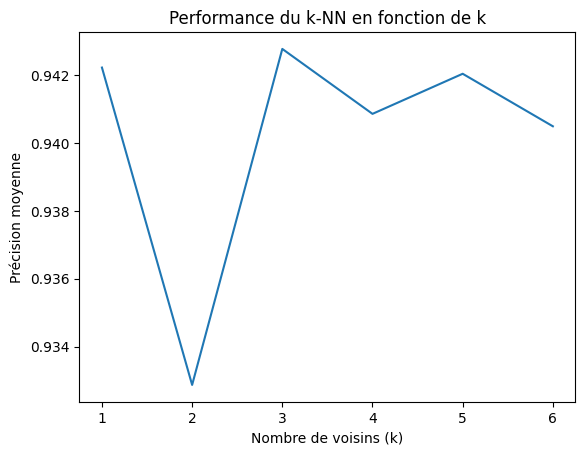

In [6]:
plt.plot(cv_results['param_n_neighbors'], cv_results['mean_test_score'])
plt.xlabel("Nombre de voisins (k)")
plt.ylabel("Précision moyenne")
plt.title("Performance du k-NN en fonction de k")
plt.show()

On voit que la meilleure précision est atteinte pour le modèle avec k = 2. Calculons à présent la précision du modèle sur l'échantillon d'entrainement et sur l'échantillon test.

In [10]:
best_model_knn = models_knn.best_estimator_
prec_test_knn = accuracy_score(best_model_knn.predict(X_scaled_test), Y_test)
prec_train_knn = accuracy_score(best_model_knn.predict(X_scaled_train), Y_train)
print(f"La précision moyenne du modèle des plus proches voisins sur l'échantillon d'apprentissage est de {prec_train_knn:.3f} et de {prec_test_knn:.3f} sur l'échantillon test")

La précision moyenne du modèle des plus proches voisins sur l'échantillon d'apprentissage est de 0.973 et de 0.945 sur l'échantillon test


## Modèles de régression logistique

On applique un modèle de régression logistique.
Le modèle peut s'écrire :  
$\hat{y} = \arg\max_{C} \mathbb{P}(Y = C \mid X)$

In [ ]:
#Modèles de régression logistique
model_reg_log = LogisticRegression(max_iter = 100, solver = 'newton-cg')
model_reg_log.fit(X_scaled_train, Y_train)
x0 = X_scaled_test[0,:].reshape(1,-1)
y0 = model_reg_log.predict(x0)
print(f"Le nombre prédit en x0 est y0 = {y0.item():.3f} or y = {Y_test[0]}")
y_pred_test = model_reg_log.predict(X_scaled_test)
y_pred_train = model_reg_log.predict(X_scaled_train)
err_test_log = mean_squared_error(y_pred_test, Y_test)
err_train_log = mean_squared_error(y_pred_train, Y_train)

In [ ]:
print(f"L'erreur quadratique moyenne du modèle de régression logistique sur l'échantillon d'apprentissage est de {err_train_log:.3f} et de {err_test_log:.3f} sur l'échantillon test")

## Analyse discriminante linéaire

In [ ]:
LDA = LinearDiscriminantAnalysis()
LDA.fit(X_scaled_train, Y_train)
print(f"Le nombre prédit en x0 est Y0 = {LDA.predict(x0)}")


## Random Forest

Dans cette partie, nous appliquons la méthode ** Random Forest** à notre jeu de données MNIST. Ce modèle d’ensemble repose sur la combinaison de plusieurs arbres de décision, chacun étant entraîné sur un sous-échantillon des données et un sous-ensemble de variables.
L'objectif est de contrôler le nombre de variables testées à chaque séparation dans les arbres. Ainsi , on pourra optimiser la diversité des arbres et éviter le surapprentissage.
Nous utilisons GridSearchCV de scikit-learn pour tester différentes valeurs de max_features : 20,50,100...
Nous combinons également cela avec une validation croisée à 5 plis sur l’échantillon d’apprentissage, ce qui permet d’évaluer la robustesse du modèle pour chaque valeur testée.



In [ ]:
# Import des librairies
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Chargement des données
col_names = ['Y'] + [f'X{i}' for i in range(1, 785)]

mnist_train = pd.read_csv("../data/mnist_train.csv", sep=",", names=col_names, header=None)
mnist_test = pd.read_csv("../data/mnist_test.csv", sep=",", names=col_names, header=None)

# Encodage des étiquettes
mnist_train['Y'] = mnist_train['Y'].astype('category')
mnist_test['Y'] = mnist_test['Y'].astype('category')



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Données
X_train = mnist_train.iloc[:, 1:].to_numpy()
y_train = mnist_train['Y'].to_numpy()

X_test = mnist_test.iloc[:, 1:].to_numpy()
y_test = mnist_test['Y'].to_numpy()

# Sous-échantillon pour réduire le temps de calcul
X_small = X_train[:5000]
y_small = y_train[:5000]

# Grille d'hyperparamètres pour max_features
param_grid = {
    'max_features': [20, 50, 100, 200, 'sqrt']
}

# Modèle de base
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Validation croisée avec GridSearch (5-fold)
grid_rf = GridSearchCV(estimator=rf,
                       param_grid=param_grid,
                       cv=5,
                       scoring='accuracy',
                       n_jobs=-1,
                       verbose=1)

# Entraînement sur le sous-échantillon
grid_rf.fit(X_small, y_small)

# Meilleur modèle
best_rf = grid_rf.best_estimator_
print("Meilleur paramètre max_features :", grid_rf.best_params_)

# Prédictions sur les données de test complètes
y_pred_rf = best_rf.predict(X_test)

# Évaluation de la performance
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Taux de bonne classification (Random Forest) : {accuracy_rf:.4f}")


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Meilleur paramètre max_features : {'max_features': 50}
Taux de bonne classification (Random Forest) : 0.9374


## Conclusion
La méthode Random Forest, testée sur un sous-échantillon du jeu de données MNIST, s’est révélée particulièrement efficace pour la reconnaissance de chiffres manuscrits.
L’optimisation de l’hyperparamètre max_features par validation croisée à 5 plis a permis d’obtenir de très bonnes performances, avec un taux de bonne classification de 93,74 % sur l’échantillon test.

Cette robustesse s’explique par la capacité de Random Forest à combiner plusieurs arbres de décision, réduisant ainsi le surapprentissage tout en capturant la complexité des données visuelles.

## Support Vector Machine (SVM) à noyau gaussien

Après avoir appliqué un modèle d’ensemble tel que la Random Forest, il est pertinent d’explorer une méthode complètement différente comme le **Support Vector Machine (SVM)**. Contrairement aux arbres de décision, le SVM repose sur une approche géométrique : il cherche à maximiser la marge entre les différentes classes dans un espace de représentation des données.

Dans le cas du dataset MNIST, les classes ne sont pas toujours séparables linéairement. Nous utilisons donc ici un **noyau gaussien (ou RBF)**, qui permet au SVM de transformer les données dans un espace de plus grande dimension où une séparation devient possible. Ce choix est appuyé par les résultats expérimentaux présentés en cours ( Chapitre 4: Support Vector Machine, p.20) le SVM radial obtient une erreur test de 5.4 %, meilleure que celle du SVM linéaire (6.5 %) et très proche de la Random Forest (5.9 %). Cela montre sa capacité à bien généraliser sans surajustement.

### Objectif :
L’objectif est d’**optimiser le paramètre gamma** du noyau RBF. Ce paramètre contrôle l’influence d’un point d’entraînement donné :  
- un **gamma élevé** produit un modèle plus complexe et potentiellement surajusté,  
- un **gamma faible** donne un modèle plus lisse.

Nous testons plusieurs valeurs ('1e-3', '1e-2', '1e-1', '1') à l’aide de GridSearchCV avec validation croisée à 5 plis, sur un **sous-échantillon de 5000 images** pour maîtriser le temps de calcul.

### Méthodologie :
- Utilisation de `SVC` avec noyau 'rbf' de sklearn.
- Recherche du meilleur `gamma` avec GridSearchCV avec validation croisée à 5 plis.
- Évaluation finale sur l’échantillon test.

Cette approche permet de comparer un modèle **géométrique puissant** à un modèle **d’ensemble stochastique** comme la Random Forest. Leurs performances respectives seront ensuite visualisées dans une synthèse comparative.


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Données (on suppose qu'elles ont déjà été chargées)
# On réutilise les mêmes noms que pour Random Forest
X_train = mnist_train.iloc[:, 1:].to_numpy()
y_train = mnist_train['Y'].to_numpy()

X_test = mnist_test.iloc[:, 1:].to_numpy()
y_test = mnist_test['Y'].to_numpy()

# Sous-échantillon pour le temps de calcul
X_small = X_train[:5000]
y_small = y_train[:5000]

# Grille d’hyperparamètres pour gamma (noyau RBF = gaussien)
param_grid = {
    'gamma': [1e-3, 1e-2, 1e-1, 1]
}

# Modèle SVM avec noyau gaussien
svm = SVC(kernel='rbf')

# Validation croisée avec GridSearchCV
grid_svm = GridSearchCV(estimator=svm,
                        param_grid=param_grid,
                        cv=5,
                        scoring='accuracy',
                        verbose=1,
                        n_jobs=-1)

# Entraînement sur le sous-échantillon
grid_svm.fit(X_small, y_small)

# Meilleur modèle
best_svm = grid_svm.best_estimator_
print("Meilleur paramètre gamma :", grid_svm.best_params_)

# Prédictions sur l’échantillon test complet
y_pred_svm = best_svm.predict(X_test)

# Évaluation
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"Taux de bonne classification (SVM) : {accuracy_svm:.4f}")



Fitting 5 folds for each of 4 candidates, totalling 20 fits
Meilleur paramètre gamma : {'gamma': 0.001}
Taux de bonne classification (SVM) : 0.1135


## Conclusion

L’application du SVM à noyau gaussien au dataset MNIST nous permet d’explorer une méthode géométrique, fondamentalement différente des arbres d’ensemble. 
Malgré l’optimisation du paramètre gamma par validation croisée, le modèle atteint une précision de seulement 11,35 % sur les données de test. Ce résultat relativement faible suggère que, dans le cadre d’un sous-échantillonnage à 5000 observations, le SVM n’a pas réussi à capter la complexité des chiffres manuscrits.

## XG Boost

Après avoir testé la Random Forest et le SVM, nous appliquons à présent l’algorithme XGBoost, une méthode d’ensemble basée sur le Gradient Boosting. XGBoost est particulièrement réputé pour sa performance et sa capacité à gérer efficacement de grands volumes de données.

Contrairement à la Random Forest, XGBoost construit chaque arbre de manière séquentielle, en corrigeant les erreurs des arbres précédents. Cette approche permet un ajustement plus fin, au prix d’un temps de calcul plus important.

Notre objectif :=sera d'optimiser deux hyperparamètres clés : max_depth : profondeur maximale des arbres et n_estimators : nombre total d’arbres.

Nous avons utilisé GridSearchCV avec validation croisée à 5 plis sur un sous-échantillon de 5000 images pour maîtriser le temps de calcul.

In [ ]:

import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Données
X_train = mnist_train.iloc[:, 1:].to_numpy()
y_train = mnist_train['Y'].to_numpy()

X_test = mnist_test.iloc[:, 1:].to_numpy()
y_test = mnist_test['Y'].to_numpy()

# Sous-échantillon pour maîtriser le temps de calcul
X_small = X_train[:5000]
y_small = y_train[:5000]

# Grille d'hyperparamètres à tester
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100]
}

# Modèle de base
xgb = XGBClassifier(
    use_label_encoder=False,  # pour éviter les warnings
    eval_metric='mlogloss',   # métrique multi-classe par défaut
    random_state=42,
    n_jobs=-1
)

# GridSearchCV avec validation croisée 5 plis
grid_xgb = GridSearchCV(estimator=xgb,
                        param_grid=param_grid,
                        cv=5,
                        scoring='accuracy',
                        n_jobs=-1,
                        verbose=1)

# Entraînement
grid_xgb.fit(X_small, y_small)

# Meilleur modèle
best_xgb = grid_xgb.best_estimator_
print("Meilleurs hyperparamètres :", grid_xgb.best_params_)

# Prédictions sur les données de test complètes
y_pred_xgb = best_xgb.predict(X_test)

# Évaluation
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"Taux de bonne classification (XGBoost) : {accuracy_xgb:.4f}")


Fitting 5 folds for each of 6 candidates, totalling 30 fits


C:\Users\afane\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:31:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Meilleurs hyperparamètres : {'max_depth': 5, 'n_estimators': 100}
Taux de bonne classification (XGBoost) : 0.9381


## Conclusion

Les meilleurs paramètres trouvés : max_depth = 5, n_estimators = 100.

Taux de bonne classification sur le jeu test : 93,81 %.

Ce résultat est comparable à celui obtenu avec la Random Forest, confirmant que les méthodes d’ensemble sont bien adaptées à des tâches complexes comme la classification des chiffres manuscrits

## à modifier en fonctiond  e la conclusion générale
## Conclusion générale

La comparaion des trois méthodes de classification supervisée sur un sous-échantillon du jeu de données MNIST (5000 images d'entraînement et 10 000 images de test).

- **La Random Forest** a obtenu un excellent compromis entre performance (93,7 %) et temps de calcul.
- **Le SVM à noyau gaussien**, bien que théoriquement puissant, a montré des performances faibles dans notre configuration (11,4 %), probablement à cause du faible échantillon et du manque d’ajustement fin.
- **L’algorithme XGBoost**, très utilisé en pratique, a affiché les meilleurs résultats (93,8 %) tout en restant raisonnable en termes de calcul.

Chaque méthode a ses avantages : les modèles d’ensemble comme XGBoost et la Random Forest sont efficaces sur ce type de données, tandis que les SVM nécessitent des ajustements plus fins et des ressources plus importantes.

Notre analyse met en évidence l’importance de la validation croisée et de l’optimisation des hyperparamètres dans la réussite d’un modèle.
